<a href="https://colab.research.google.com/github/andressriosg/Topicos-en-Estadistica/blob/main/modelolstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files # Para cargar archivos en google colab
uploaded = files.upload()

Saving serie_completa.csv to serie_completa.csv


In [2]:
import pandas as pd
import io
serie_covid1 = io.BytesIO(uploaded['serie_completa.csv'])
serie_covid = pd.read_csv(serie_covid1, sep = ",", encoding="latin-1")
serie_covid.head(4)

,Fecha,Frecuencia
0,2020-02-27,1
1,2020-02-28,2
2,2020-02-29,2
3,2020-03-01,4


In [4]:
serie_covid.tail(4)

,Fecha,Frecuencia
1415,2024-01-12,53
1416,2024-01-13,21
1417,2024-01-14,9
1418,2024-01-15,1


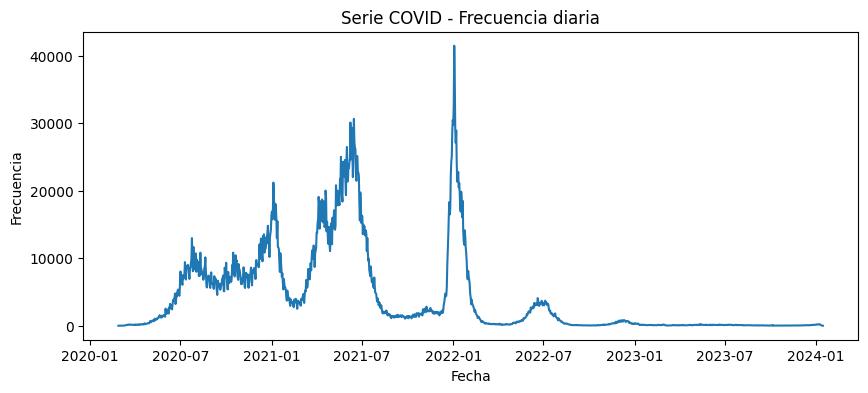

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

serie_covid['Fecha'] = pd.to_datetime(serie_covid['Fecha'])
serie_covid = serie_covid.sort_values('Fecha').reset_index(drop=True) # Ordenar por fecha por si acaso
plt.figure(figsize=(10,4))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'])
plt.title('Serie COVID - Frecuencia diaria')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()

In [15]:
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_covid['Frecuencia'].values.reshape(-1, 1)) # Acá se hace un escalamiento de los datos
serie_scaled

array([[0.00000000e+00],
       [2.41062604e-05],
       [2.41062604e-05],
       ...,
       [4.82125208e-04],
       [1.92850083e-04],
       [0.00000000e+00]])

In [16]:
def crear_secuencias(data, pasos): # Para crear ventanas temporales
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i + pasos])
        y.append(data[i + pasos])
    return np.array(X), np.array(y)
# data = [10, 20, 30, 40, 50, 60, 70], pasos = 3 (ventana de 3 días). Los bucles generados sera así [10, 20, 30]

pasos = 30 # Tamaño de ventana temporal (por ejemplo 30 días)
X, y = crear_secuencias(serie_scaled, pasos)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# X.shape = (1389, 30, 1) Hay 1389 datos, cada uno con de 30 filas y 1 columna

X.shape = (1389, 30, 1), y.shape = (1389, 1)


In [17]:
train_size = int(len(X) * 0.8) # División del conjunto de datos
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

print("X_train:", X_train.shape, ", Tamaño entrenamiento: {len(X_train)}")
print("y_train:", y_train.shape, ", Tamaño validación: {len(X_val)}")

X_train: (1111, 30, 1) , Tamaño entrenamiento: {len(X_train)}
y_train: (1111, 1) , Tamaño validación: {len(X_val)}


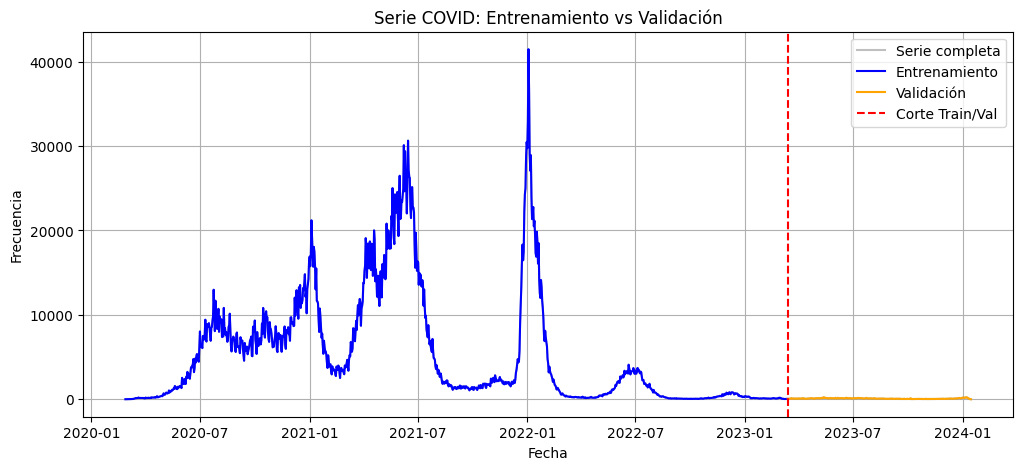

In [116]:
fecha_entrenamiento = serie_covid['Fecha'][:train_size]
fecha_validacion = serie_covid['Fecha'][train_size:]

plt.figure(figsize=(12,5))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], color='gray', alpha=0.5, label='Serie completa')

plt.plot(fecha_entrenamiento, serie_covid['Frecuencia'][:train_size], color='blue', label='Entrenamiento')
plt.plot(fecha_validacion, serie_covid['Frecuencia'][train_size:], color='orange', label='Validación')

# Líneas divisorias
plt.axvline(x=serie_covid['Fecha'].iloc[train_size], color='red', linestyle='--', label='Corte Train/Val')

plt.title('Serie COVID: Entrenamiento vs Validación')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()

In [117]:
dim_entrada = (X_train.shape[1],1) # Cada entrada es una secuencia de 30 pasos temporales, con una sola característica por paso temporal.
dim_salida = 1 # El modelo debe predecir un solo valor (por ejemplo, el siguiente valor en la secuencia).
na = 200 # La red tendrá una capa oculta con 60 neuronas, lo que afecta su capacidad de aprendizaje.

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

modelo = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')
])

modelo.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
modelo.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 30)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,333 (118.49 KB)

 Trainable params: 30,333 (118.49 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = modelo.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0357 - val_loss: 0.0010
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0194 - val_loss: 0.0040
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0061 - val_loss: 6.3481e-04
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0055 - val_loss: 1.6296e-04
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0038 - val_loss: 2.8237e-04
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0038 - val_loss: 2.6828e-04
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0058 - val_loss: 2.2510e-04
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0037 - val_loss: 2.2257e-04
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 1.7210e-04
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0036 - val_loss: 1.3956e-04
Epoch 12/300
35/35 ━

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

val_loss = np.array(hist.history['val_loss'])
train_loss = np.array(hist.history['loss'])
best_epoch = np.argmin(val_loss)
print(f"Mejor época (mínimo val_loss): {best_epoch+1} (0-based index {best_epoch})")
print(f"val_loss_min = {val_loss[best_epoch]:.6e}, train_loss en esa época = {train_loss[best_epoch]:.6e}")

Mejor época (mínimo val_loss): 21 (0-based index 20)
val_loss_min = 1.403001e-06, train_loss en esa época = 2.224326e-03


In [121]:
modelo.fit(X_train,y_train, epochs= best_epoch, batch_size=32) # Entrenamiento

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0021
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0021
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0018
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0018
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0019
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016
Epoc

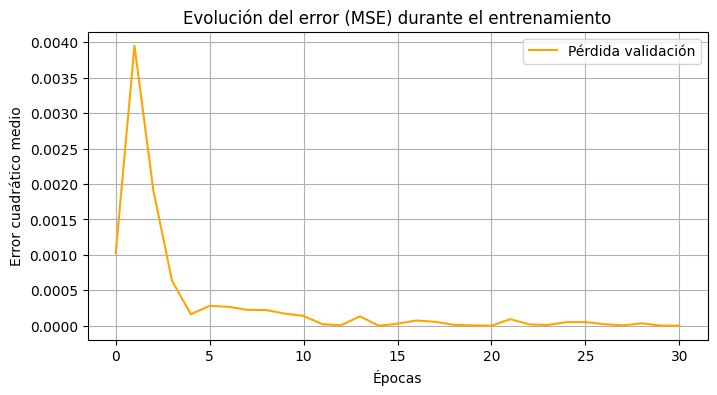

In [122]:
plt.figure(figsize=(8,4))
# plt.plot(hist.history['loss'], label='Pérdida entrenamiento', color='blue')
plt.plot(hist.history['val_loss'], label='Pérdida validación', color='orange')
plt.title('Evolución del error (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


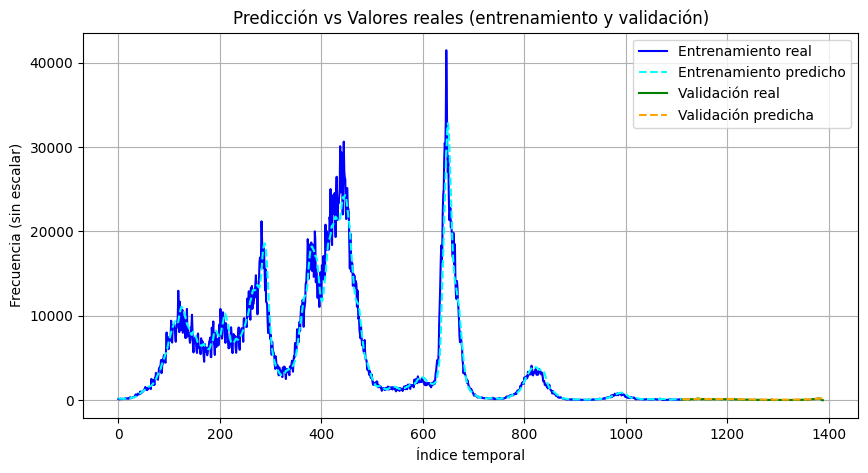

    Real    Predicho
0   62.0  108.492310
1   50.0  108.142899
2   78.0  106.512566
3   65.0  105.121269
4   81.0  103.499939
5   84.0  102.343193
6   78.0  101.778694
7   96.0  101.512024
8  122.0  102.182686
9  104.0  104.613716


In [123]:
pred_train = modelo.predict(X_train)
pred_val = modelo.predict(X_val)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1)) # Desescala tanto el entrenamiento como la validación
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
pred_train_inv = scaler.inverse_transform(pred_train)
pred_val_inv = scaler.inverse_transform(pred_val)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Entrenamiento real', color='blue')
plt.plot(np.arange(len(y_train_inv)), pred_train_inv, label='Entrenamiento predicho', color='cyan', linestyle='--')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), y_val_inv, label='Validación real', color='green')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), pred_val_inv, label='Validación predicha', color='orange', linestyle='--')
plt.title('Predicción vs Valores reales (entrenamiento y validación)')
plt.xlabel('Índice temporal')
plt.ylabel('Frecuencia (sin escalar)')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparación en tabla ---
comparacion = pd.DataFrame({
    'Real': y_val_inv.flatten(),
    'Predicho': pred_val_inv.flatten()
})
print(comparacion.head(10))

In [124]:
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv)))
print(" R2:", r2_score(y_val_inv, pred_val_inv))


Evaluación en validación:
 MAE: 32.597351938700506
 RMSE: 40.631920547122235
 R2: 0.21357766234249398


In [125]:
ventana = 30  # o el número de pasos que usaste al crear las secuencias
ultimos_datos_scaled = serie_scaled[-ventana:]  # últimos 30 valores de la serie escalada
ultimos_datos_scaled = ultimos_datos_scaled.reshape(1, ventana, 1)  # formato 3D (batch, timesteps, features)
print(ultimos_datos_scaled.shape)

(1, 30, 1)


In [126]:
n_pred = 15  # número de días a predecir
ventana = 30  # mismo tamaño de ventana
X_pred = ultimos_datos_scaled.copy()
predicciones_futuras = []

for _ in range(n_pred):
    pred = modelo.predict(X_pred, verbose=0)  # pred.shape = (1, 1)
    predicciones_futuras.append(pred[0, 0])
    nuevo_valor = np.reshape(pred, (1, 1, 1)) # Convertir la predicción en la misma forma (1, 1, 1)
    X_pred = np.concatenate([X_pred[:, 1:, :], nuevo_valor], axis=1) # Concatenar correctamente (manteniendo las 3 dimensiones)

# Convertir a array y desescalar
predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

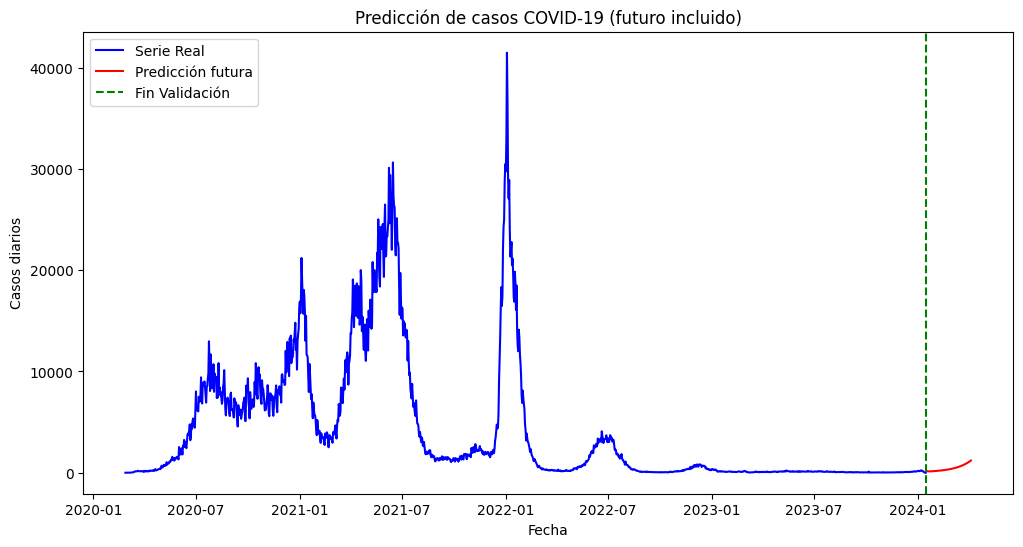

In [127]:
n_futuro = 80

ult_fecha = serie_covid['Fecha'].max() # 2. Crear fechas futuras
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2]) # 3. Predicción futura
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    # Redimensionar pred a (1,1,1) para concatenar correctamente
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1) # 4. Inversa de escalado
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

plt.figure(figsize=(12, 6)) # 5. Gráfico
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')

plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido)')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ====== Definición del modelo GRU ======
modelo1 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dense(1)
])

# ====== Compilación del modelo ======
modelo1.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0170 - val_loss: 4.0529e-05
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0017 - val_loss: 1.5713e-05
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0013 - val_loss: 7.4100e-06
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0012 - val_loss: 4.2160e-07
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0012 - val_loss: 5.5083e-05
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0012 - val_loss: 1.5361e-06
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0011 - val_loss: 3.4196e-05
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0010 - val_loss: 7.0044e-07
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 9.8420e-04 - val_loss: 4.6434e-05
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 9.2487e-04 - val_loss: 4.6630e-06
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0010 - val_loss: 5.4816e-05

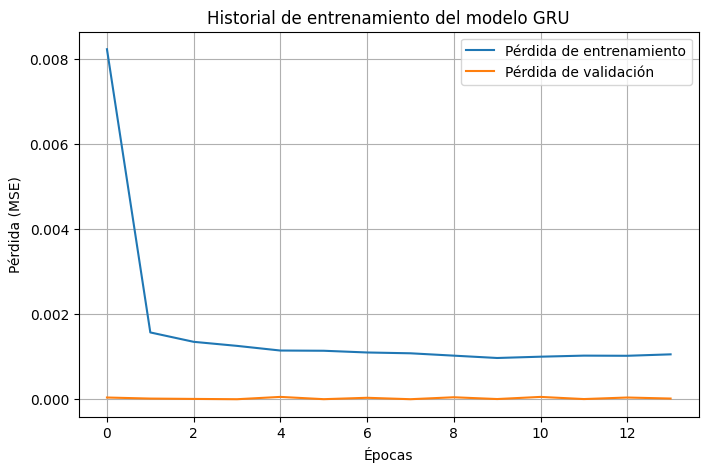

In [135]:
# ====== Early stopping para evitar overfitting ======
early_stop1 = EarlyStopping(
    monitor='val_loss',       # Métrica de validación a vigilar
    patience=10,              # Detener si no mejora en 10 épocas
    restore_best_weights=True # Restaurar los mejores pesos
)

# ====== Entrenamiento ======
hist1 = modelo1.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop1],
    verbose=1
)

# ====== Gráfico del historial ======
plt.figure(figsize=(8,5))
plt.plot(hist1.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist1.history['val_loss'], label='Pérdida de validación')
plt.title('Historial de entrenamiento del modelo GRU')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
pred_train1 = modelo1.predict(X_train)
pred_val1 = modelo1.predict(X_val)

pred_train_inv1 = scaler.inverse_transform(pred_train1)
pred_val_inv1 = scaler.inverse_transform(pred_val1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [137]:
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv1))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv1)))
print(" R2:", r2_score(y_val_inv, pred_val_inv1))


Evaluación en validación:
 MAE: 20.24863303822579
 RMSE: 26.935312233904785
 R2: 0.6544068163066132


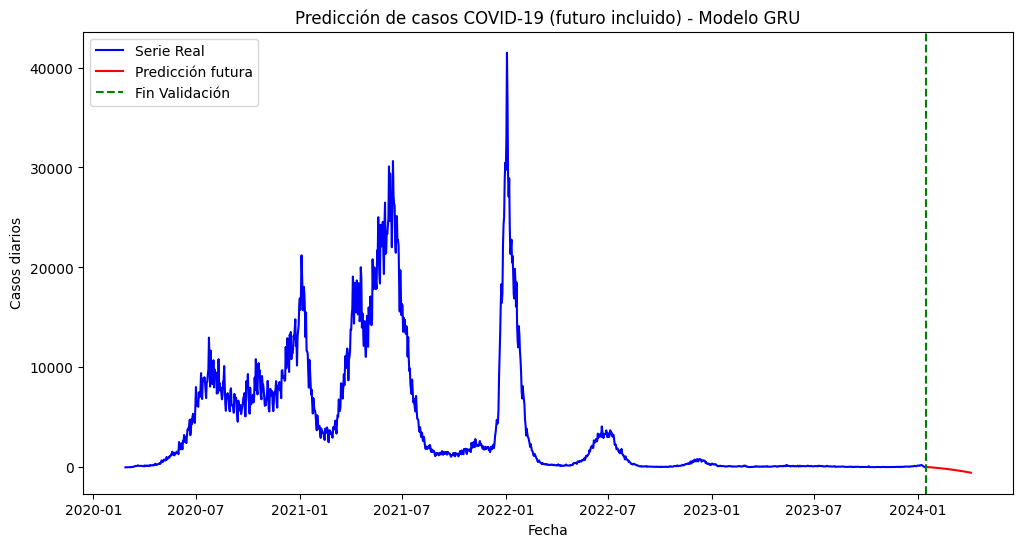

In [141]:
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2])
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo1.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

# 7. Gráfico general
plt.figure(figsize=(12, 6))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()